# Exploring Fractals

Exploring different fractals

In [62]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['image.cmap'] = 'viridis'

Mandelbrot set

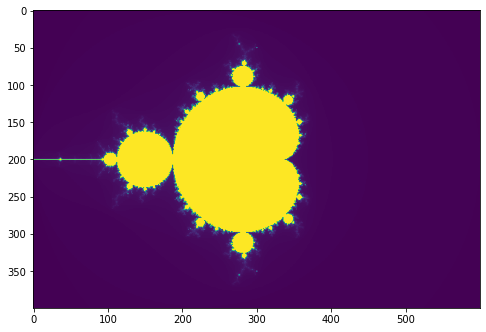

In [8]:
size = 600, 400
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i in range(size[0]):
    for j in range(size[1]):
        c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
        z = 0
        n = 0
        while abs(z) < 2 and n < 255:
            z *= z
            z += c
            n += 1
        image[j, i] = n
        
plt.imshow(image);

Polynomial roots fractal using Newton's method

Define complex polynomial function $f(z)$ and find roots of function using Newton's method

$$
z_{n+1} = z_n - \frac{f(z_n)}{f'(z_n)}
$$

We're going to focus on cubic functions now (which have three roots)

$$
f(z) = (z - r_1)(z - r_2)(z - r_3) 
$$

We can use the product rule to differentiate in this form. The product rule has a useful symmetry that we can exploit

$$
(p r q)' = p'rq + p r'q + p r q'
$$

Since $p$, $q$, and $r$ all take the form of $z - c$ (where $c$ is a constant), each of their individual derivatives reduces to $1$. So we can rewrite the derivative as follows

$$
f'(z) = (z - r_2)(z - r_3) + (z - r_1)(z - r_3) + (z - r_2)(z - r_3)
$$

In [84]:
def iterator(z, r):
    """
    Iterate z through one step of newton's method
    """
    d = r.shape[0]
    p = (z - r)
    f = np.prod(p)
    pp = np.meshgrid(p, p)[0]
    pp *= np.ones((d, d)) * (1 - np.eye(d))
    pp += np.eye(d)
    pp = np.prod(pp, axis=0)
    fp = np.sum(pp)
    return z - f/fp

# Return index of root nearest to z
arg_nearest_root = lambda z, r: np.argmin(np.abs(z - r))

If we run the iteration for a grid of complex numbers and color them based on the root that they landed on. We can see a beautiful fractal pattern emerge

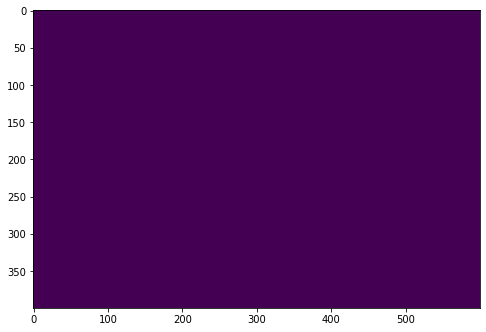

In [86]:
# Create image
size = 600, 400
iterations = 10
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Create polynomial from complex roots
roots = np.exp(np.linspace(0, 2*np.pi, 3))

# Run algorithm for each pixel
for i in range(size[0]):
    for j in range(size[1]):
        z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
        for _ in range(iterations):
            z = iterator(z, roots)
        image[j, i] = arg_nearest_root(z, roots)
        
# Show image
image = np.linspace(0, 1, roots.shape[0])[image]
plt.imshow(image);
plt.show();